In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *

from joblib import Parallel, delayed
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
# from tqdm_joblib import tqdm_joblib

np.set_printoptions(linewidth=120)

In [3]:
target = np.load('../pretrained_models/Enformer_data/enformer_targets_test_center_2.npy')
print(target.shape)

pred = np.load(f'outputs/Enformer_pred_crop_196608_N.npy')
print(pred.shape)

corr = np.corrcoef(pred.reshape(-1), target.reshape(-1))[0, 1]
print(corr)

(1937, 2, 5313)
(1937, 2, 5313)
0.7913763071882721


In [22]:
for cropped_length in [8192, 16384, 32768]:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N.npy')
    pred_new = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N_new.npy')

    print(np.all((pred-pred_new)<0.01))
    print(pred[0,0,:20])
    print(pred_new[0,0,:20])

True
[0.113 0.129 0.143 0.139 0.09  0.101 0.138 0.152 0.153 0.133 0.139 0.138 0.17  0.154 0.134 0.14  0.172 0.209 0.225
 0.112]
[0.113 0.129 0.143 0.139 0.09  0.101 0.138 0.152 0.153 0.133 0.139 0.138 0.17  0.154 0.134 0.14  0.172 0.209 0.225
 0.112]
True
[0.085 0.099 0.109 0.125 0.084 0.09  0.124 0.126 0.143 0.1   0.092 0.129 0.144 0.123 0.109 0.128 0.138 0.162 0.172
 0.082]
[0.085 0.099 0.109 0.125 0.084 0.09  0.124 0.126 0.143 0.1   0.092 0.129 0.144 0.123 0.109 0.128 0.138 0.162 0.172
 0.082]
True
[0.08  0.087 0.102 0.121 0.09  0.095 0.121 0.12  0.146 0.09  0.081 0.122 0.139 0.111 0.1   0.122 0.129 0.15  0.155
 0.072]
[0.08  0.087 0.102 0.121 0.09  0.095 0.121 0.12  0.146 0.09  0.081 0.122 0.139 0.111 0.1   0.122 0.129 0.15  0.155
 0.072]


In [4]:
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [ ]:
def compute_metrics_for_each_column_parallel(target, pred, n_jobs=-1):
    num_samples, num_positions, num_tracks = target.shape
    with tqdm_joblib(tqdm(desc="my task", total=num_tracks)) as progress_bar:
        results = Parallel(n_jobs=n_jobs)(
            delayed(pearson)(target[:, :, i].reshape(-1), pred[:, :, i].reshape(-1)) for i in range(num_tracks)
        )
    return np.vstack(results)

In [5]:
# import re
# folder_path = "outputs"

# pattern = re.compile(r"(Enformer_pred_crop_\d+)_pad_196608_random_5_times")

# for filename in os.listdir(folder_path):
#     match = pattern.search(filename)
#     if match:
#         base = match.group(1)
#         new_filename = pattern.sub(f"{base}_random_5_times", filename)
#         old_path = os.path.join(folder_path, filename)
#         new_path = os.path.join(folder_path, new_filename)

#         if os.path.exists(new_path):
#             print(f"文件已存在：{new_filename}，跳过")
#         else:
#             os.rename(old_path, new_path)
#             print(f"重命名：{filename} -> {new_filename}")

In [6]:
length_list = np.array([256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 196608])
positions = np.log2(length_list)

In [15]:
# pad zero
pred_list = []
score_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_N.npy')
    # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_zero.npy')
    # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_random.npy')
    # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_genome.npy')
    # pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_repeat.npy')
    pred_list.append(pred)
    score = compute_metrics_for_each_column_parallel(target, pred)
    score_list.append(score)
pred_list = np.stack(pred_list)
score_list = np.stack(score_list)

np.save('Enformer_score_N', score_list)
# np.save('Enformer_score_zero.npy', score_list)
# np.save('Enformer_score_random.npy', score_list)
# np.save('Enformer_score_genome.npy', score_list)
# np.save('Enformer_score_repeat.npy', score_list)

my task:   0%|          | 0/5313 [00:00<?, ?it/s]

my task: 100%|██████████| 5313/5313 [00:00<00:00, 8779.52it/s]


(5313, 2)


my task: 100%|██████████| 5313/5313 [00:00<00:00, 9346.17it/s] 


(5313, 2)


my task: 100%|██████████| 5313/5313 [00:00<00:00, 9503.89it/s] 


(5313, 2)


my task: 100%|██████████| 5313/5313 [00:00<00:00, 10581.71it/s]


(5313, 2)


my task: 100%|██████████| 5313/5313 [00:00<00:00, 10366.89it/s]


(5313, 2)


my task: 100%|██████████| 5313/5313 [00:00<00:00, 9730.06it/s] 


(5313, 2)


my task: 100%|██████████| 5313/5313 [00:00<00:00, 9747.83it/s] 


(5313, 2)


my task: 100%|██████████| 5313/5313 [00:00<00:00, 9906.95it/s] 


(5313, 2)


my task: 100%|██████████| 5313/5313 [00:00<00:00, 9828.72it/s] 


(5313, 2)


my task: 100%|██████████| 5313/5313 [00:00<00:00, 10174.83it/s]


(5313, 2)


my task: 100%|██████████| 5313/5313 [00:00<00:00, 9377.99it/s] 


(5313, 2)


In [14]:
score_list.shape

(11, 5313, 2)

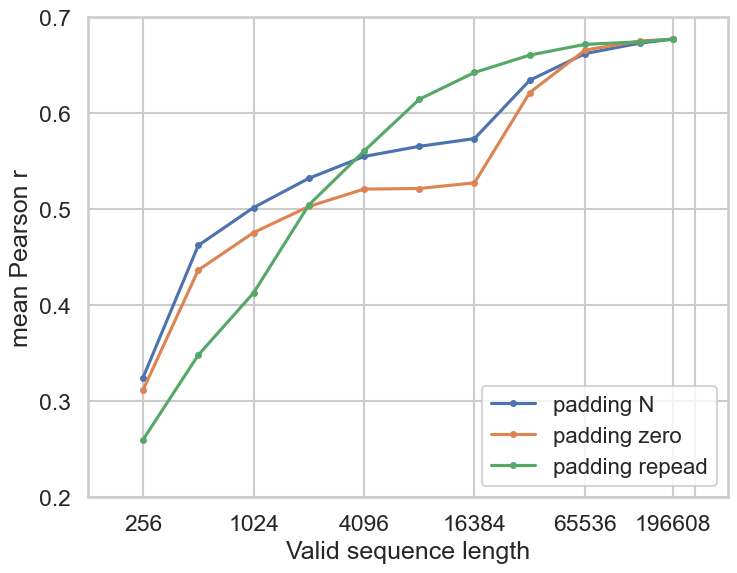

In [16]:
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)

score_list = np.load('Enformer_score_N.npy')
data = np.nanmean(score_list[:, :, 0], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding N')

score_list = np.load('Enformer_score_zero.npy')
data = np.nanmean(score_list[:, :, 0], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding zero')

# score_list = np.load('Enformer_score_random.npy')
# data = np.nanmean(score_list[:, :, 0], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding random')

# score_list = np.load('Enformer_score_genome.npy')
# data = np.nanmean(score_list[:, :, 0], axis=1)
# plt.plot(positions, data, marker="o", markersize=4, label='padding genome')

score_list = np.load('Enformer_score_repeat.npy')
data = np.nanmean(score_list[:, :, 0], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding repead')

x_ticks = [8, 10, 12, 14, 16, 16+np.log2(3), 18]
x_labels = [256, 1024, 4096, 16384, 65536, 196608, '']



plt.xlim(np.min(positions)-1, np.max(positions)+1)
plt.ylim(0.2, 0.7)
plt.xticks(x_ticks, x_labels)
plt.yticks(np.arange(0.2, 0.71, 0.1))
plt.xlabel('Valid sequence length')
plt.ylabel('mean Pearson r')
plt.legend(fontsize=16, loc='lower right')
plt.savefig('figures/Enformer_padding_AUROC_line.png', dpi=400)
plt.show()

In [12]:
# # enformer

# plt.figure(figsize=(8, 6), dpi=100)
# plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)


# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}.npy')
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='w/o padding')


# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_zero.npy')
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='zero padding')


# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_N.npy')
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='N padding')



# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
#     # print(pred.shape)
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# pred_list = pred_list.mean(1)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding')





# plt.xlim(7, 19)
# plt.ylim(0.1, 0.9)
# plt.xticks([8, 10, 12, 14, 16, 16+np.log2(3), 18], labels=[256, 1024, 4096, 16384, 65536, 196608, ''])
# plt.yticks(0.1 * np.arange(1, 10))
# plt.xlabel('Valid sequence length')
# plt.ylabel('Pearson correlation')
# plt.legend(fontsize=16, loc='lower right')
# plt.savefig('figures/correlation_between_3_padding_methods.png', dpi=400)
# plt.savefig('figures/correlation_between_3_padding_methods.pdf', dpi=400)
# plt.show()

[0.14831763 0.2190007  0.32825761 0.42501433 0.50697009 0.67599033 0.73477368 0.73628863 0.73806766 0.73806766]
[0.14961445 0.21899548 0.32970724 0.42660532 0.50855883 0.67742352 0.73501291 0.73659921 0.73806766 0.73806766]


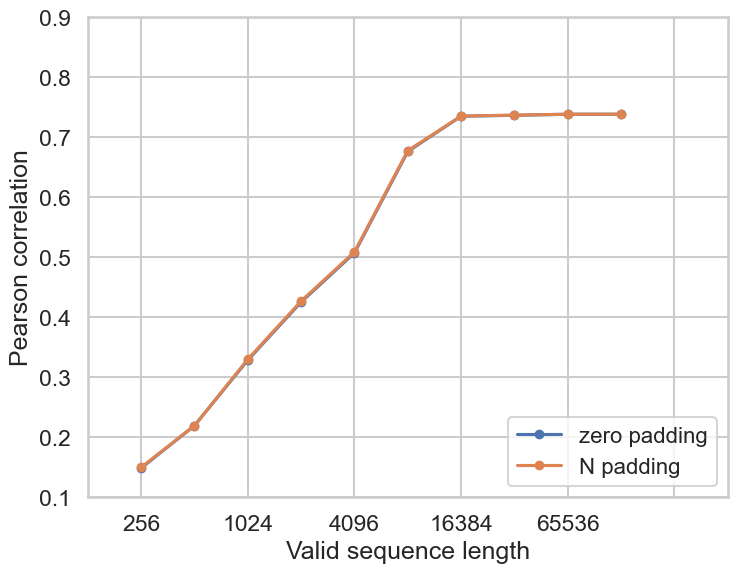

In [9]:
# basenji2

plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)

length_list = np.array([256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072])
target = np.load('data/enformer_targets_test_center_2.npy')
# print(target.shape)


# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}.npy')
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='w/o padding')


pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}_pad_131072_zero.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
print(corr)
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='zero padding')


pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}_pad_131072_N.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
print(corr)
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='N padding')



# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}_pad_131072_random_5_times.npy')
#     # print(pred.shape)
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# pred_list = pred_list.mean(1)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding')





plt.xlim(7, 19)
plt.ylim(0.1, 0.9)
plt.xticks([8, 10, 12, 14, 16, 18], labels=[256, 1024, 4096, 16384, 65536, ''])
plt.yticks(0.1 * np.arange(1, 10))
plt.xlabel('Valid sequence length')
plt.ylabel('Pearson correlation')
plt.legend(fontsize=16, loc='lower right')
plt.savefig('figures/correlation_between_3_padding_methods.png', dpi=400)
plt.savefig('figures/correlation_between_3_padding_methods.pdf', dpi=400)
plt.show()

(11, 5, 1937, 2, 5313)
(11, 5, 1937, 2, 5313)


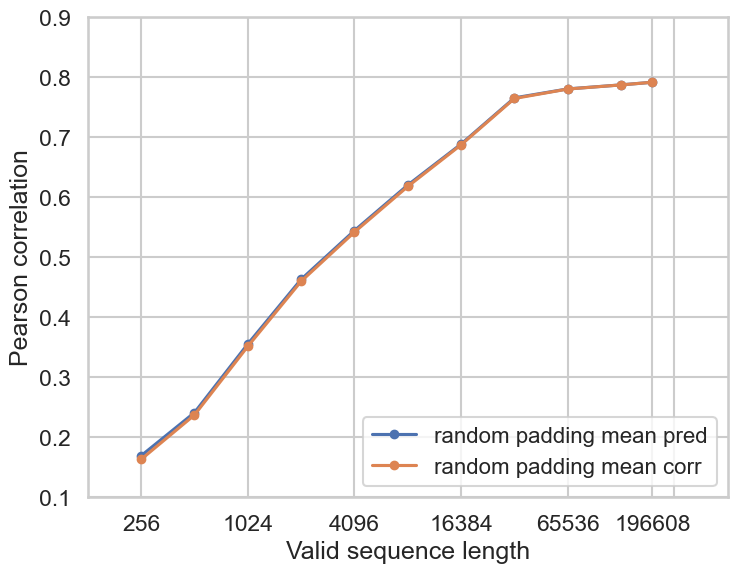

In [4]:
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)




pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
pred_list = pred_list.mean(1)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding mean pred')



pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
# (11, 5, 1937, 2, 5313)
pred_list = pred_list.reshape(-1, 1937, 2, 5313)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1].reshape(-1, 5).mean(1)
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding mean corr')




plt.xlim(7, 19)
plt.ylim(0.1, 0.9)
plt.xticks([8, 10, 12, 14, 16, 16+np.log2(3), 18], labels=[256, 1024, 4096, 16384, 65536, 196608, ''])
plt.yticks(0.1 * np.arange(1, 10))
plt.xlabel('Valid sequence length')
plt.ylabel('Pearson correlation')
plt.legend(fontsize=16, loc='lower right')
plt.savefig('figures/correlation_random_mean.png', dpi=400)
plt.show()

In [5]:
pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
# (11, 5, 1937, 2, 5313)
pred_list = pred_list.reshape(-1, 1937, 2, 5313)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))

print(corr)

(11, 5, 1937, 2, 5313)
[[1.         0.91465899 0.91662061 ... 0.16742964 0.16742964 0.16327258]
 [0.91465899 1.         0.91243314 ... 0.16608902 0.16608902 0.16096631]
 [0.91662061 0.91243314 1.         ... 0.16871918 0.16871918 0.16371049]
 ...
 [0.16742964 0.16608902 0.16871918 ... 1.         1.         0.79138096]
 [0.16742964 0.16608902 0.16871918 ... 1.         1.         0.79138096]
 [0.16327258 0.16096631 0.16371049 ... 0.79138096 0.79138096 1.        ]]
